In [310]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, squareform

# Gaussian processes

In this note, we implement a Gaussian process (GP) regression model.<br>
A GP is completely characterized by the mean function $m(x)$ and the covariance function $k(x,x')$ of a real random process $f(x)$ [[1]](#1),
$$
\begin{aligned}
m(x) &= \mathbb{E}\left[f(x)\right],\\
k(x,x') &= \mathbb{E}\left[(f(x)-m(x))(f(x')-m(x'))\right].
\end{aligned}
$$

Here, we assume that the covariance function is given by the squared exponential (SE) function,
$$
k(x,x') = \exp\left\{-\frac{1}{2}\left|x-x'\right|^2\right\},
$$
or
$$
K(\mathbf{x},\mathbf{x}') = \exp\left\{-\frac{1}{2}\left(\mathbf{x}-\mathbf{x'}\right)\left(\mathbf{x}-\mathbf{x'}\right)^\top\right\},
$$
where $\mathbf{x}=\{x_1,x_2,\dots,x_n\}$ with $n$ being the data points.

In [311]:
def kernel(X0,X1,size):
    X_dists = cdist(X0,X1, 'sqeuclidean')
    return np.exp(-X_dists/2)

With this, we can generate a series of predictions $\mathbf{f}_*$ from a random Gaussian process (*a prior*) as shown below,
$$
\mathbf{f}_*\sim \mathcal{N}(\mathbf{0},K(\mathbf{x}_*,\mathbf{x}_*)).
$$

### Generating functions from a GP

Generating $\mathbf{f}_*$ from a GP with an arbitrary mean $\mathbf{m}$ and covariant matrix $K$ can be done as follows.<br>
First, perform the Cholesky decomposition to obtain a lower triangular matrix $L$,
$$
K = L L^\top.
$$
Second, generate a series of random numbers $\mathbf{u}\sim \mathcal{N}(\mathbf{0},I)$ from a Gaussian random number generator.<br>
A generated function values are then obtained by
$$
\mathbf{f}_* = \mathbf{m} + L\mathbf{u}.
$$

In [312]:
def f_gen(K,size):
    return np.linalg.cholesky(K+ 1e-9*np.identity(size))@np.random.normal(0,1,size)

Note that in the function an arbitrary small number is added for the numerical stability.

In [313]:
size = 100
X = np.linspace(-5,5,size).reshape(-1,1)
X_dists = cdist(X,X,'sqeuclidean')
KXsXs   = kernel(X,X,size)
fstar = np.array([f_gen(KXsXs,size) for i in range(5)]).T
fs_std = np.sqrt(np.diag(KXsXs))

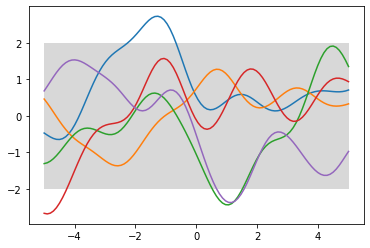

In [314]:
plt.figure()
plt.fill_between(X.flatten(),2*fs_std,-2*fs_std,color='grey',alpha=0.3,ec=None)
plt.plot(X,fstar)
plt.show()

### Training the GP regression model.

The prior should be updated with the observations (or the training data) $\{x_i,f_i|i=1,\dots,n\}$.

The distribution of predictions given the observations reads
$$
\begin{aligned}
p\left(\mathbf{f}_*|\mathbf{x}_*,\mathbf{x},\mathbf{f}\right)\sim \mathcal{N}(&K(\mathbf{x}_*,\mathbf{x})K(\mathbf{x},\mathbf{x})^{-1}\mathbf{x},\\
&K(\mathbf{x}_*,\mathbf{x}_*)-K(\mathbf{x}_*,\mathbf{x})K(\mathbf{x},\mathbf{x})^{-1}K(\mathbf{x},\mathbf{x}_*)).
\end{aligned}
$$

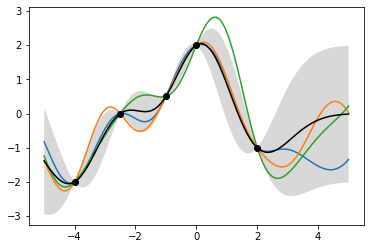

In [309]:
X_train = np.array([-4,-2.5,-1,0,2]).reshape(-1,1)
f_train = np.array([-2,0,0.5,2,-1])
KXsX  = kernel(X,X_train,size)
KXX   = kernel(X_train,X_train,size)
K     = KXsXs - KXsX@np.linalg.inv(KXX)@KXsX.T
f_mean = KXsX@np.linalg.inv(KXX)@f_train
f_devi = np.array([f_gen(K,size) for i in range(3)]).T
f_std = np.sqrt(np.diag(K))
plt.figure()
plt.scatter(X_train,f_train,zorder=np.inf,color='k')
plt.fill_between(X.flatten(),f_mean+2*f_std,f_mean-2*f_std,color='grey',alpha=0.3,ec=None)
plt.plot(X,f_mean.reshape(-1,1)+f_devi)
plt.plot(X,f_mean,'k')
plt.show()

## References
<a id="1">[1]</a>
C. E. Rasmussen and C. K. I. Williams (2006).
Gaussian Processes for Machine Learning, volume 38. The MIT Press, Cambridge, MA, USA, 2006.